In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

In [2]:
test_results_path = "./data/SWOW_prediction/eval/"

In [3]:
properties = ["previous_link", "polarity"]
model_name = "bert-base-uncased"  # change to xlm-roberta-large for other results
reduces = [
    "forward",
    "both",
]
data_name = "coha"
train_sections = np.arange(0, 5)
loss_function_name = "likelihood_loss"
graph_strategy = "ppmi"
token_strategy = "frequency"
graph_version = 2
swow_version = 1
fill = "add"
add_self_loops = True
sections = ["dev", "test"]
baselines = [True, False]

In [5]:
list_rows = []

for property in properties:

    for baseline in baselines:

        for reduce in reduces:
            for section in sections:
                total_df = pd.DataFrame()

                for train_section in train_sections:

                    if baseline == True:
                        df_dir = (
                            test_results_path
                            + f"{property}_basic_{data_name}_{train_section}_{loss_function_name}_graph_{graph_strategy}_graph_version_{graph_version}_swow_version_{swow_version}_fill_{fill}_add_self_loops_{add_self_loops}_token_strategy_{token_strategy}_{section}.csv"
                        )
                    else:
                        df_dir = (
                            test_results_path
                            + f"{property}_{model_name}_{reduce}_{data_name}_{train_section}_{loss_function_name}_graph_{graph_strategy}_graph_version_{graph_version}_swow_version_{swow_version}_fill_{fill}_add_self_loops_{add_self_loops}_token_strategy_{token_strategy}_{section}.csv"
                        )

                    if not os.path.exists(df_dir):
                        continue

                    df = pd.read_csv(df_dir)
                    total_df = pd.concat((total_df, df), ignore_index=True)
                if len(total_df) == 0:
                    continue
                # print(len(total_df), property, baseline, reduce, train_section)
                df = (
                    total_df.groupby(["words"])[["targets", "outputs"]]
                    .mean()
                    .reset_index()
                )

                r, p = pearsonr(df.targets, df.outputs)
                n = len(df)
                r2 = r2_score(df.targets, df.outputs)
                m = None
                if baseline == True:
                    m = "BERT"
                elif reduce == "both":

                    m = "GCN + BERT"

                elif reduce == "forward":
                    m = "GCN"

                row = {
                    "model": m,
                    "r": float(r),
                    "p": p,
                    "r2": r2,
                    "train_section": train_section,
                    "test_section": section,
                    "property": property,
                    "n": n,
                }
                list_rows.append(row)

results = pd.DataFrame(list_rows)

In [6]:
print(
    results.loc[results.test_section == "test"]
    .groupby(["model", "property"])[["r", "r2", "n", "p"]]
    .mean()
    .reset_index()
    .sort_values(by=["property", "r", "r2", "n", "p"]),
)

        model       property         r        r2      n              p
0        BERT       polarity  0.554589  0.202877  843.0   3.737951e-69
2         GCN       polarity  0.650891  0.407108  843.0  9.797190e-103
4  GCN + BERT       polarity  0.675090  0.446931  843.0  3.265968e-113
3         GCN  previous_link  0.657124  0.429032  937.0  6.655570e-117
1        BERT  previous_link  0.660778  0.433500  937.0  1.237305e-118
5  GCN + BERT  previous_link  0.668719  0.444697  937.0  1.764675e-122


previous_link 0.668662332982656 1.881481546611636e-122 937
polarity 0.6750017717495188 3.5799236515821835e-113 843


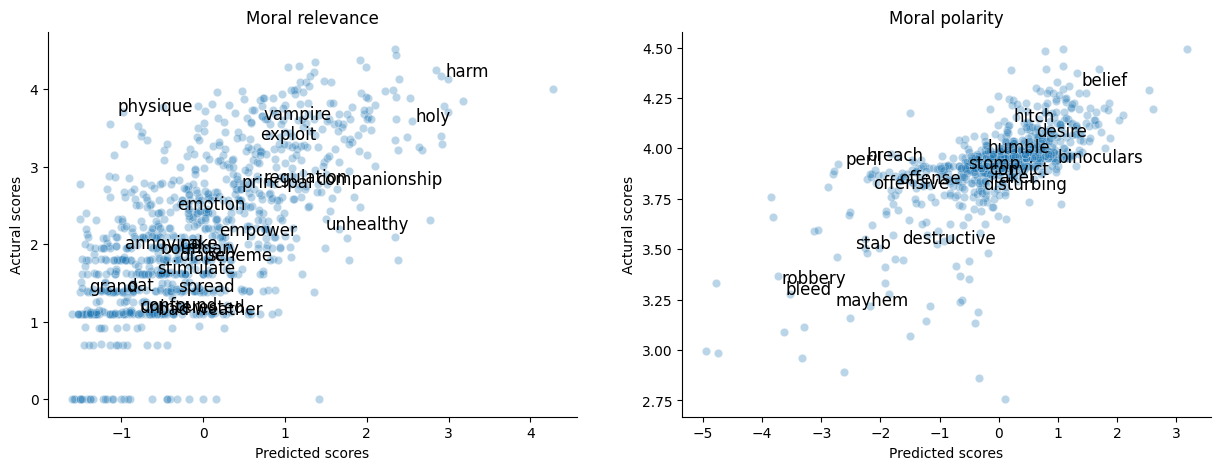

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
total_df = pd.DataFrame()
for train_section in range(5):
    section = "test"
    reduce = "both"
    property = "previous_link"
    df_dir = (
        test_results_path
        + f"{property}_{model_name}_{reduce}_{data_name}_{train_section}_{loss_function_name}_graph_{graph_strategy}_graph_version_{graph_version}_swow_version_{swow_version}_fill_{fill}_add_self_loops_{add_self_loops}_token_strategy_{token_strategy}_{section}.csv"
    )
    df = pd.read_csv(df_dir)
    df["section"] = [train_section] * len(df)
    mean_val = df["outputs"].mean()
    std_val = df["outputs"].std()
    df["z_score"] = df["outputs"].apply(lambda x: (x - mean_val) / std_val)
    total_df = pd.concat((total_df, df), ignore_index=True)
total_df = total_df.groupby(["words"]).mean().reset_index()
r, p = pearsonr(total_df.targets, total_df.z_score)
n = len(total_df)
print(property, r, p, n)
ax = axes[0]
sns.scatterplot(data=total_df, y="targets", x="z_score", alpha=0.3, ax=ax)
for i, row in df.iterrows():
    random_choice = np.random.rand()
    if random_choice >= 0.975:
        ax.text(y=row["targets"], x=row["z_score"], s=row["words"], size=12)
ax.set_title("Moral relevance")
ax.set_xlabel("Predicted scores")
ax.set_ylabel("Actural scores")
total_df = pd.DataFrame()
for train_section in range(5):
    section = "test"
    reduce = "both"
    property = "polarity"
    df_dir = (
        test_results_path
        + f"{property}_{model_name}_{reduce}_{data_name}_{train_section}_{loss_function_name}_graph_{graph_strategy}_graph_version_{graph_version}_swow_version_{swow_version}_fill_{fill}_add_self_loops_{add_self_loops}_token_strategy_{token_strategy}_{section}.csv"
    )
    df = pd.read_csv(df_dir)
    df["section"] = [train_section] * len(df)
    mean_val = df["outputs"].mean()
    std_val = df["outputs"].std()
    df["z_score"] = df["outputs"].apply(lambda x: (x - mean_val) / std_val)
    total_df = pd.concat((total_df, df), ignore_index=True)
total_df = total_df.groupby(["words"]).mean().reset_index()
r, p = pearsonr(total_df.targets, total_df.z_score)
n = len(total_df)
print(property, r, p, n)
ax = axes[1]
sns.scatterplot(data=total_df, y="targets", x="z_score", alpha=0.3, ax=ax)
for i, row in df.iterrows():
    random_choice = np.random.rand()

    if random_choice >= 0.99:
        plt.text(y=row["targets"], x=row["z_score"], s=row["words"], size=12)
    if row["z_score"] < -1.5:
        random_choice = np.random.rand()
        if random_choice >= 0.8:
            plt.text(y=row["targets"], x=row["z_score"], s=row["words"], size=12)

ax.set_title("Moral polarity")
ax.set_xlabel("Predicted scores")
ax.set_ylabel("Actural scores")

sns.despine()
plt.show()